In [52]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates and 2) asymmetry in nuclear genome

In [21]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)
mut_vert = pd.read_csv('../data/MutSpecALLvert.csv')

In [34]:
mut_vert['MutBase'] = mut_vert.Mut.str.slice(2,5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,A[A>C]A,0.000424,A>C,AAA
1,A[A>C]C,0.001497,A>C,AAC
2,A[A>C]G,0.000197,A>C,AAG
3,A[A>C]T,0.000000,A>C,AAT
4,A[A>G]A,0.014522,A>G,AAA


In [25]:
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


In [45]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

In [59]:
to_96_comp = []
for num_subs in range(0,96):
    # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
    anc = assymetry.iloc[num_subs, 0]
    mb = assymetry.iloc[num_subs, 1]
    # get reverse subs with context
    rev_anc = gettranslate(anc, reverse=True)
    rev_mb = gettranslate(mb, reverse=False)
    # find mutspec num for the mutbase and context same with reverse, than devide on reverse
    rev_mutspec = mut_vert[(mut_vert.MutBase == rev_mb) & (mut_vert.AncestorCodon == rev_anc)].MutSpec.values[0]
    mutspec = mut_vert[(mut_vert.MutBase == mb) & (mut_vert.AncestorCodon == anc)].MutSpec.values[0]
    new_96_mut = mutspec/rev_mutspec
    #define row for future df
    out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
    to_96_comp.append(out_mut)

mut_96_comp = pd.DataFrame(to_96_comp)
mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].replace(np.inf, 0)
mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].fillna(0)
mut_96_comp.head()
    

/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_14586/3797007472.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_14586/3797007472.py:12: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.000000
1,ACA,C>G,0.000000
2,ACA,C>T,3.473528
3,ACC,C>A,0.000000
4,ACC,C>G,0.000000


In [61]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry.head()

,AncestorCodon,MutBase,T,R,MutSpec
0,ACA,C>A,-0.171181,-0.373510,0.000000
1,ACA,C>G,0.065067,0.034147,0.000000
2,ACA,C>T,-0.012015,-0.052744,3.473528
3,ACC,C>A,-0.091167,-0.285840,0.000000
4,ACC,C>G,0.091991,0.144789,0.000000


In [67]:
final_asymmetry['T'].values

array([-0.17118062,  0.06506702, -0.01201507, -0.09116746,  0.09199053,
        0.02855645, -0.12727663, -0.06116554,  0.07174731, -0.12979359,
        0.1892969 , -0.08805798, -0.24955231, -0.32075421, -0.0748251 ,
       -0.2216924 , -0.28735508, -0.05709805, -0.12466502, -0.24052907,
       -0.12221296, -0.1487335 , -0.26991437,  0.10408342, -0.06498826,
        0.04536004,  0.17985673,  0.01021717,  0.10195186,  0.18000638,
       -0.02861122,  0.06789686,  0.17604523,  0.0149927 ,  0.17166896,
        0.11526051, -0.13235352, -0.23169502, -0.01884944, -0.11628336,
       -0.11130001, -0.03190266, -0.03324539, -0.17276487, -0.02746773,
        0.02118772, -0.12405224,  0.06222161, -0.07899726,  0.05169139,
        0.04473298, -0.04292718,  0.03459656,  0.0210991 , -0.08808813,
        0.03034268,  0.12193717, -0.05560197,  0.15159614, -0.13827539,
       -0.1662281 , -0.22533345, -0.10031489, -0.11375029, -0.20745205,
        0.00652584, -0.07292574, -0.19305648, -0.05381691, -0.07

In [71]:
stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)

SpearmanrResult(correlation=0.3366035874725818, pvalue=0.0007987165578151938)

In [69]:
stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)

SpearmanrResult(correlation=0.2855464344574589, pvalue=0.004801016324322085)

<AxesSubplot:xlabel='MutSpec', ylabel='T'>

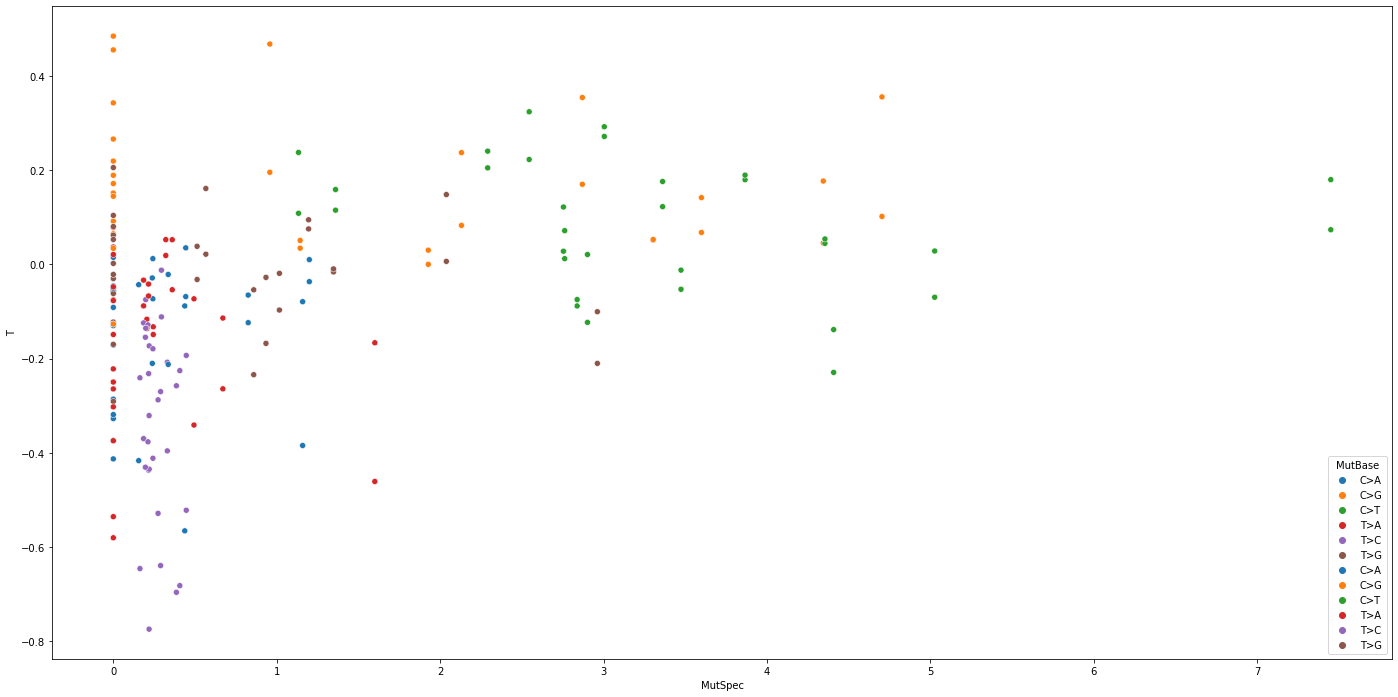

In [76]:
fig = plt.figure(figsize=(24, 12))
sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='MutBase')


<AxesSubplot:xlabel='MutSpec', ylabel='R'>

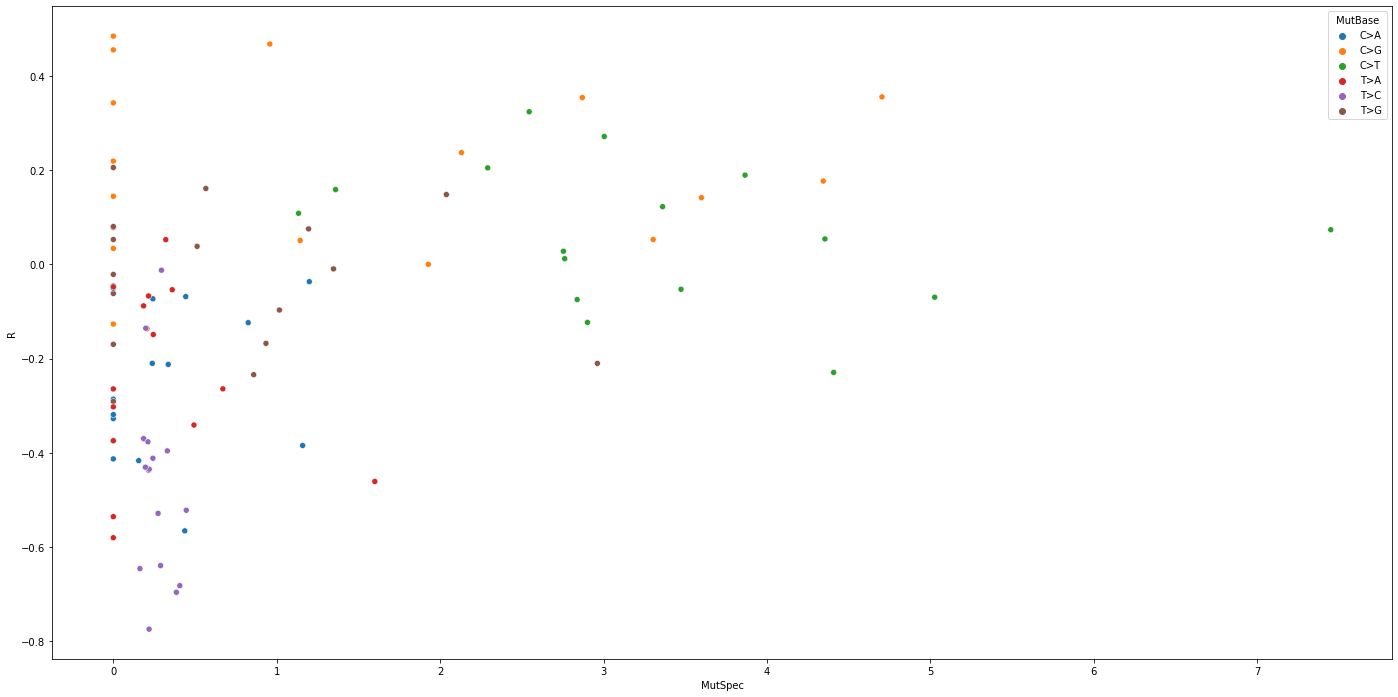

In [77]:
fig = plt.figure(figsize=(24, 12))
sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='MutBase')